In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
from convex_lib import ConvexNN
from nflib.flows import SequentialFlow, NormalizingFlow, ActNorm
import nflib.res_flow as irf
import nflib

In [4]:
class DistanceRegressor(nn.Module):
    def __init__(self, input_dim, inv_temp=1):
        super().__init__()
        self.centers = nn.Parameter(torch.rand(1, input_dim)*2-1)
        self.bias = nn.Parameter(torch.ones(1)*-0.5)
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)

        
    def forward(self, x):
        x = torch.norm(x-self.centers, dim=-1, keepdim=True)
#         x = -x*self.inv_temp + self.bias
        x = x*self.inv_temp + self.bias
        return x

## 2D dataset -> Monotonic

In [5]:
from scipy.stats import multivariate_normal

def gaussian(x1_mean, x2_mean, std, x1_grid, x2_grid, yscale):
    rv = multivariate_normal([x1_mean, x2_mean], [[std, 0.], [0., std]])
    data = np.dstack((x1_grid.reshape(-1), x2_grid.reshape(-1)))
    z = rv.pdf(data)
    z = z/z.max()*yscale
    return z.reshape(x1_grid.shape)

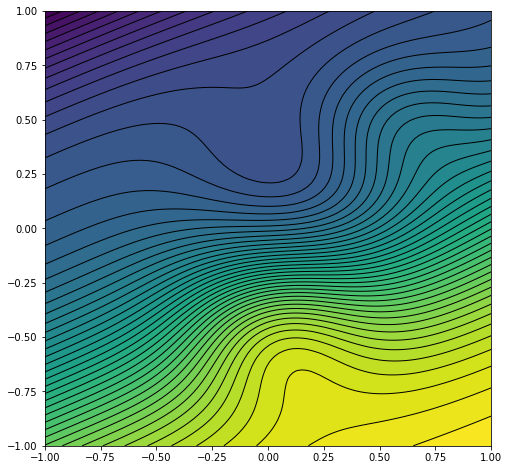

In [6]:
num_points = 100
X1 = np.linspace(-2.5, 1.9, num_points)
# X1 = np.linspace(-2.5, 2.5, num_points)
# X2 = np.linspace(-2.5, 3, num_points)
X2 = np.linspace(-2.2, 2.9, num_points)
X1, X2 = np.meshgrid(X1, X2)
# Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1. - 0.1*(X1)+0.02*(X2)
Y = -X1*0.5 + X2
Y = np.sin(Y*1.3 + 0.5)*0.5+Y
Y += gaussian(0, 0.5, 0.5, X1, X2, 0.5)
Y -= gaussian(-0.75, 1.0, 1, X1, X2, 0.1)
Y += gaussian(0.75, 1.0, 1.2, X1, X2, 0.75)
Y -= gaussian(1.0, 1.5, 0.4, X1, X2, 1.0)
Y -= gaussian(-0.25, -0.75, 0.4, X1, X2, 1.3)




####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1
Y = -Y/2

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

xx = torch.Tensor(np.c_[x1, x2])
yy = torch.Tensor(Y.reshape(-1,1))

# %matplotlib tk
# ax = plt.figure(figsize=(8,6)).add_subplot(projection='3d')
# ax.plot_surface(X1, X2, Y, cmap='plasma')
# ax.set_xlabel('X1')
# ax.set_ylabel('X2')
# ax.set_zlabel('Y')
# plt.show()

LVLs = 50
plt.figure(figsize=(8,8))
plt.contourf(X1, X2, Y, levels=LVLs)
cs = plt.contour(X1, X2, Y, levels=LVLs, linestyles="None", colors="k", linewidths=1)

<a list of 19 text.Text objects>

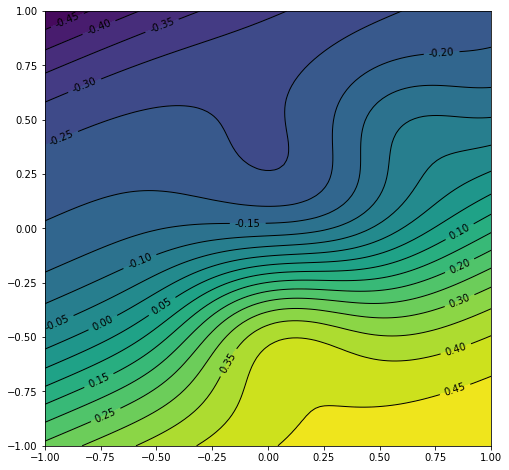

In [8]:
LVLs = 20
plt.figure(figsize=(8,8))
plt.contourf(X1, X2, Y, levels=LVLs)
cs = plt.contour(X1, X2, Y, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")

In [9]:
# gaussian(0, 0, 4, X1, X2, 0.2).shape

In [10]:
# from scipy.stats import multivariate_normal

# x, y = np.mgrid[-10:10:.1, -10:10:.1]
# rv = multivariate_normal([0, 0], [[1.0, 0.], [0., 1.0]])
# data = np.dstack((x, y))
# z = rv.pdf(data)
# z = z/z.max()
# plt.contourf(x, y, z)
# plt.axis("equal")
# plt.show()

In [11]:
# z.max(), z.min()

# Convex NN

In [12]:
EPOCHS = 5000
# actf = nn.LeakyReLU
actf = nn.ELU
learning_rate = 0.005
criterion = nn.MSELoss()

In [13]:
cvxNet = ConvexNN([2, 15, 15, 1], actf)
optimizer = torch.optim.Adam(cvxNet.parameters(), lr=learning_rate)

In [14]:
%matplotlib tk
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

for epoch in range(EPOCHS):

    yout = cvxNet(xx)    
    loss = criterion(yout, yy)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch%100 == 0 or epoch==EPOCHS-1:
        print(f'Epoch: {epoch}, Loss:{float(loss)}')
        ax.clear()
        ax.scatter(X1, X2, yy.data.numpy().reshape(-1), marker= '.')
        ax.scatter(X1, X2, yout.data.numpy().reshape(-1), color='r', marker='.')
        ax2.clear()
        ax2.contourf(X1, X2, yout.data.numpy().reshape(Y.shape), levels=20)

        fig.canvas.draw()
        plt.pause(0.01)
plt.close()

Epoch: 0, Loss:0.18578164279460907
Epoch: 100, Loss:0.004721103236079216
Epoch: 200, Loss:0.004519955720752478
Epoch: 300, Loss:0.004264351446181536
Epoch: 400, Loss:0.003925468306988478
Epoch: 500, Loss:0.0035194018855690956
Epoch: 600, Loss:0.003145349444821477
Epoch: 700, Loss:0.0028763951268047094
Epoch: 800, Loss:0.0027182097546756268
Epoch: 900, Loss:0.002647134941071272
Epoch: 1000, Loss:0.0026206187903881073
Epoch: 1100, Loss:0.0026054694317281246
Epoch: 1200, Loss:0.002597975777462125
Epoch: 1300, Loss:0.0025934111326932907
Epoch: 1400, Loss:0.0025895554572343826
Epoch: 1500, Loss:0.0025864453054964542
Epoch: 1600, Loss:0.0025828888174146414
Epoch: 1700, Loss:0.0025696284137666225
Epoch: 1800, Loss:0.0025601708330214024
Epoch: 1900, Loss:0.002549700438976288
Epoch: 2000, Loss:0.0025405201595276594
Epoch: 2100, Loss:0.002530793659389019
Epoch: 2200, Loss:0.00251841195859015
Epoch: 2300, Loss:0.0025157839991152287
Epoch: 2400, Loss:0.002511825878173113
Epoch: 2500, Loss:0.002504

In [ ]:
# %matplotlib inline

# y_ = yout.data.cpu().numpy().reshape(Y.shape)

# fig = plt.figure(figsize=(8,6))
# ax = fig.gca(projection='3d')
# ax.view_init(49, -71)
# ax.plot_surface(X1, X2, y_, cmap='plasma', alpha=0.9)
# ax.set_xlabel('X1')
# ax.set_ylabel('X2')
# ax.set_zlabel('Y')
# # plt.pause(0.1)
# plt.show()

<a list of 17 text.Text objects>

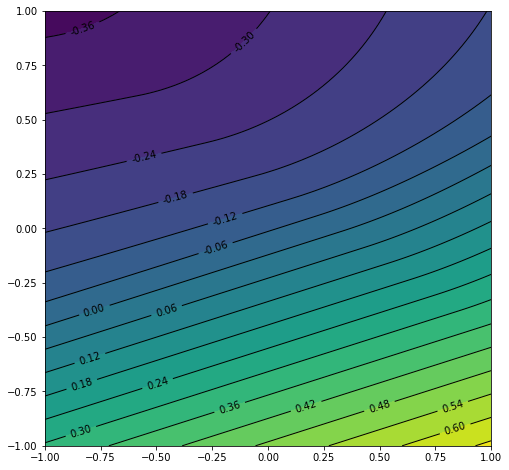

In [16]:
# LVLs = np.linspace(sim.min(), sim.max(), 20)
LVLs = 20

y_ = cvxNet(xx).data.cpu().numpy().reshape(Y.shape)

plt.figure(figsize=(8,8))
plt.contourf(X1, X2, y_, levels=LVLs)
cs = plt.contour(X1, X2, y_, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")
# minima = xx[y_.argmin()]
# plt.scatter(*minima.tolist(), s=100, edgecolors="red")

## Invex NN

In [ ]:
# EPOCHS = 5000
# learning_rate = 0.005
# criterion = nn.MSELoss()

In [ ]:
# cvxNet = nn.Sequential(
#     nn.BatchNorm1d(2),
#     irf.ResidualFlow(2, [15], activation=nflib.res_flow.Swish),
#     nn.BatchNorm1d(2),
#     DistanceRegressor(2),
# )

# optimizer = torch.optim.Adam(cvxNet.parameters(), lr=learning_rate)

In [ ]:
# %matplotlib tk
# fig = plt.figure(figsize=(15,6))
# ax = fig.add_subplot(121, projection='3d')
# ax2 = fig.add_subplot(122)

# for epoch in range(EPOCHS):

#     yout = -cvxNet(xx)    
#     loss = criterion(yout, yy)
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     if epoch%100 == 0 or epoch==EPOCHS-1:
#         print(f'Epoch: {epoch}, Loss:{float(loss)}')
#         ax.clear()
#         ax.scatter(X1, X2, yy.data.numpy().reshape(-1), marker= '.')
#         ax.scatter(X1, X2, yout.data.numpy().reshape(-1), color='r', marker='.')
#         ax2.clear()
#         ax2.contourf(X1, X2, yout.data.numpy().reshape(Y.shape), levels=20)

#         fig.canvas.draw()
#         plt.pause(0.01)
# plt.close()

In [ ]:
# %matplotlib inline

# y_ = yout.data.cpu().numpy().reshape(Y.shape)

# fig = plt.figure(figsize=(8,6))
# ax = fig.gca(projection='3d')
# ax.view_init(49, -71)
# ax.plot_surface(X1, X2, y_, cmap='plasma', alpha=0.9)
# ax.set_xlabel('X1')
# ax.set_ylabel('X2')
# ax.set_zlabel('Y')
# # plt.pause(0.1)
# plt.show()

In [ ]:
# LVLs = 20

# y_ = -cvxNet(xx).data.cpu().numpy().reshape(Y.shape)

# plt.figure(figsize=(8,8))
# plt.contourf(X1, X2, y_, levels=LVLs)
# cs = plt.contour(X1, X2, y_, levels=LVLs, linestyles="None", colors="k", linewidths=1)
# plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")
# minima = xx[y_.argmin()]
# plt.scatter(*minima.tolist(), s=100, edgecolors="red")

## 2D dataset -> Local

In [ ]:
num_points = 100
X1 = np.linspace(-2.5, 1.9, num_points)
# X1 = np.linspace(-2.5, 2.5, num_points)
# X2 = np.linspace(-2.5, 3, num_points)
X2 = np.linspace(-2.2, 2.1, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1. - 0.1*(X1)+0.02*(X2)

####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1
Y = Y/2

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

xx = torch.Tensor(np.c_[x1, x2])
yy = torch.Tensor(Y.reshape(-1,1))


In [ ]:
# %matplotlib tk
ax = plt.figure(figsize=(8,6)).add_subplot(projection='3d')
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

# Convex NN

In [ ]:
EPOCHS = 5000
# actf = nn.LeakyReLU
actf = nn.ELU
learning_rate = 0.005
criterion = nn.MSELoss()

In [ ]:
cvxNet = ConvexNN([2, 15, 15, 1], actf)
optimizer = torch.optim.Adam(cvxNet.parameters(), lr=learning_rate)

In [ ]:
%matplotlib tk
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

for epoch in range(EPOCHS):

    yout = -cvxNet(xx)    
    loss = criterion(yout, yy)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch%100 == 0 or epoch==EPOCHS-1:
        print(f'Epoch: {epoch}, Loss:{float(loss)}')
        ax.clear()
        ax.scatter(X1, X2, yy.data.numpy().reshape(-1), marker= '.')
        ax.scatter(X1, X2, yout.data.numpy().reshape(-1), color='r', marker='.')
        ax2.clear()
        ax2.contourf(X1, X2, yout.data.numpy().reshape(Y.shape), levels=20)

        fig.canvas.draw()
        plt.pause(0.01)
plt.close()

In [ ]:
%matplotlib inline

y_ = yout.data.cpu().numpy().reshape(Y.shape)

fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')
ax.view_init(49, -71)
ax.plot_surface(X1, X2, y_, cmap='plasma', alpha=0.9)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
# plt.pause(0.1)
plt.show()

In [ ]:
# LVLs = np.linspace(sim.min(), sim.max(), 20)
LVLs = 20

y_ = -cvxNet(xx).data.cpu().numpy().reshape(Y.shape)

plt.figure(figsize=(8,8))
plt.contourf(X1, X2, y_, levels=LVLs)
cs = plt.contour(X1, X2, y_, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")
minima = xx[y_.argmin()]
plt.scatter(*minima.tolist(), s=100, edgecolors="red")

## Invex NN

In [ ]:
EPOCHS = 5000
learning_rate = 0.005
criterion = nn.MSELoss()

In [ ]:
cvxNet = nn.Sequential(
    nn.BatchNorm1d(2),
    irf.ResidualFlow(2, [15], activation=nflib.res_flow.Swish),
    nn.BatchNorm1d(2),
    DistanceRegressor(2),
)

optimizer = torch.optim.Adam(cvxNet.parameters(), lr=learning_rate)

In [ ]:
%matplotlib tk
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

for epoch in range(EPOCHS):

    yout = -cvxNet(xx)    
    loss = criterion(yout, yy)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch%100 == 0 or epoch==EPOCHS-1:
        print(f'Epoch: {epoch}, Loss:{float(loss)}')
        ax.clear()
        ax.scatter(X1, X2, yy.data.numpy().reshape(-1), marker= '.')
        ax.scatter(X1, X2, yout.data.numpy().reshape(-1), color='r', marker='.')
        ax2.clear()
        ax2.contourf(X1, X2, yout.data.numpy().reshape(Y.shape), levels=20)

        fig.canvas.draw()
        plt.pause(0.01)
plt.close()

In [ ]:
# %matplotlib inline

# y_ = yout.data.cpu().numpy().reshape(Y.shape)

# fig = plt.figure(figsize=(8,6))
# ax = fig.gca(projection='3d')
# ax.view_init(49, -71)
# ax.plot_surface(X1, X2, y_, cmap='plasma', alpha=0.9)
# ax.set_xlabel('X1')
# ax.set_ylabel('X2')
# ax.set_zlabel('Y')
# # plt.pause(0.1)
# plt.show()

In [ ]:
LVLs = 20

y_ = -cvxNet(xx).data.cpu().numpy().reshape(Y.shape)

plt.figure(figsize=(8,8))
plt.contourf(X1, X2, y_, levels=LVLs)
cs = plt.contour(X1, X2, y_, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")
minima = xx[y_.argmin()]
plt.scatter(*minima.tolist(), s=100, edgecolors="red")

## Linear and Radial

<a list of 15 text.Text objects>

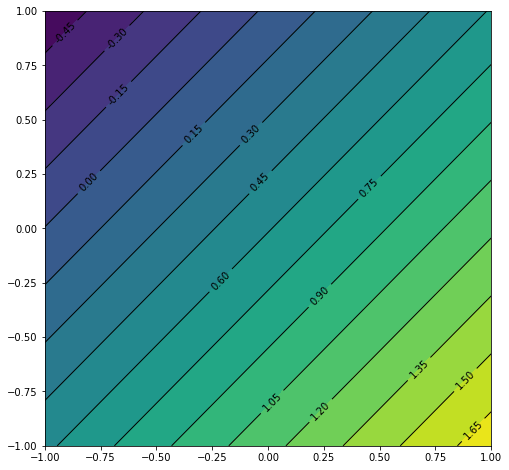

In [28]:
linear = nn.Linear(2, 1)
y = linear(xx).data.numpy().reshape(Y.shape)

LVLs = 20
plt.figure(figsize=(8,8))
plt.contourf(X1, X2, y, levels=LVLs)
cs = plt.contour(X1, X2, y, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")

<a list of 14 text.Text objects>

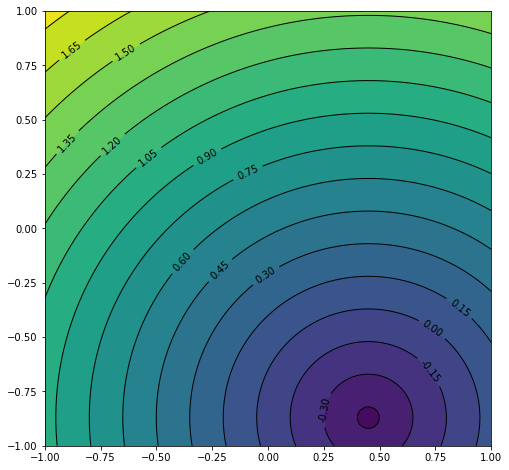

In [29]:
radial = DistanceRegressor(2, 1)
y = radial(xx).data.numpy().reshape(Y.shape)

LVLs = 20
plt.figure(figsize=(8,8))
plt.contourf(X1, X2, y, levels=LVLs)
cs = plt.contour(X1, X2, y, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")